In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
data = pd.read_csv(file_path)
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


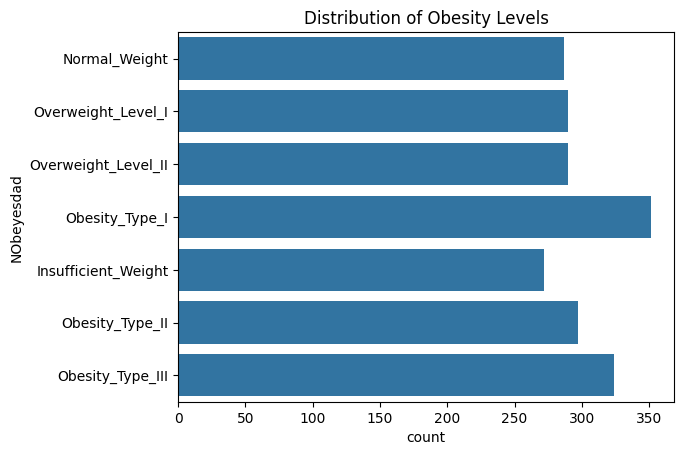

In [3]:
# Distribution of target variable
sns.countplot(y='NObeyesdad', data=data)
plt.title('Distribution of Obesity Levels')
plt.show()

In [4]:
# Standardizing continuous numerical features
continuous_columns = data.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[continuous_columns])

# Converting to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaler.get_feature_names_out(continuous_columns))

# Combining with the original dataset
scaled_data = pd.concat([data.drop(columns=continuous_columns), scaled_df], axis=1)

In [5]:
# Identifying categorical columns
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')  # Exclude target column

# Applying one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

# Converting to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Combining with the original dataset
prepped_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

In [6]:
# Encoding the target variable
prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
prepped_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Preparing final dataset
X = prepped_data.drop('NObeyesdad', axis=1)
y = prepped_data['NObeyesdad']

In [8]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Training logistic regression model using One-vs-All (default)
model_ova = LogisticRegression(multi_class='ovr', max_iter=1000)
model_ova.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'ovr'


In [10]:
# Predictions
y_pred_ova = model_ova.predict(X_test)

# Evaluation metrics for OvA
print("One-vs-All (OvA) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ova),2)}%")

One-vs-All (OvA) Strategy
Accuracy: 76.12%


In [11]:
# Training logistic regression model using One-vs-One
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ovo.fit(X_train, y_train)

,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'


In [12]:
# Predictions
y_pred_ovo = model_ovo.predict(X_test)

# Evaluation metrics for OvO
print("One-vs-One (OvO) Strategy")
print(f"Accuracy: {np.round(100*accuracy_score(y_test, y_pred_ovo),2)}%")

One-vs-One (OvO) Strategy
Accuracy: 92.2%
